# リポジトリクローン

In [ ]:
%cd /content
!rm -rf D-FINE
!git clone https://github.com/Peterande/D-FINE
%cd D-FINE

# パッケージインストール

In [ ]:
!pip install -q faster-coco-eval
!pip install -q calflops onnx onnxruntime onnxsim

# データセット準備（VOC→COCO形式）

In [ ]:
%cd /content
!git clone https://github.com/Kazuhito00/YOLOX-Colaboratory-Training-Sample.git
!git clone https://github.com/Kazuhito00/convert_voc_to_coco.git
%cd D-FINE

In [4]:
dataset_directory = '/content/YOLOX-Colaboratory-Training-Sample/02.annotation_data'

In [5]:
import os

# 学習/検証データパス(train/validation data path)
train_directory = './train'
validation_directory = './validation'

# 学習データ格納ディレクトリ作成(Create training data storage directory)
os.makedirs(train_directory, exist_ok=True)
# 検証データ格納ディレクトリ作成(Create verification data storage directory)
os.makedirs(validation_directory, exist_ok=True)

In [6]:
import glob
import shutil
import random

# 学習データの割合(Percentage of training data)
train_ratio = 0.8

# コピー元ファイルリスト取得(Get copy source file list)
annotation_list = sorted(glob.glob(dataset_directory + '/*.xml'))
image_list = sorted(glob.glob(dataset_directory + '/*.jpg'))

file_num = len(annotation_list)

# インデックスシャッフル(shuffle)
index_list = list(range(file_num - 1))
random.shuffle(index_list)

for count, index in enumerate(index_list):
    if count < int(file_num * train_ratio):
        # 学習用データ(Training Data)
        shutil.copy2(annotation_list[index], train_directory)
        shutil.copy2(image_list[index], train_directory)
    else:
        # 検証用データ(Validation Data)
        shutil.copy2(annotation_list[index], validation_directory)
        shutil.copy2(image_list[index], validation_directory)

In [7]:
# Pascal VOC形式 を MS COCO形式へ変換
!python ../convert_voc_to_coco/convert_voc_to_coco.py \
    train train/train_annotations.json \
    --start_image_id=0
!python ../convert_voc_to_coco/convert_voc_to_coco.py \
    validation validation/validation_annotations.json \
    --start_image_id=10000000

Number of xml files: 40
Convert XML to JSON: 100% 40/40 [00:00<00:00, 5953.38it/s]
{'Fish': 222}
Success: train/train_annotations.json
Number of xml files: 9
Convert XML to JSON: 100% 9/9 [00:00<00:00, 7301.50it/s]
{'Fish': 47}
Success: validation/validation_annotations.json


# 学習設定yml準備

In [8]:
%%writefile my_dfine_hgnetv2_s.yml

# configs/dfine/dfine_hgnetv2_s_coco.yml を参考

__include__: [
  'configs/dataset/coco_detection.yml',      # 変更
  'configs/runtime.yml',                     # 変更
  'configs/dfine/include/dataloader.yml',    # 変更
  'configs/dfine/include/optimizer.yml',     # 変更
  'configs/dfine/include/dfine_hgnetv2.yml', # 変更
]


output_dir: ./output/my_dfine_hgnetv2_s      # 変更


DFINE:
  backbone: HGNetv2

HGNetv2:
  name: 'B0'
  return_idx: [1, 2, 3]
  freeze_at: -1
  freeze_norm: False
  use_lab: True

DFINETransformer:
  num_layers: 3  # 4 5 6
  eval_idx: -1  # -2 -3 -4

HybridEncoder:
  in_channels: [256, 512, 1024]
  hidden_dim: 256
  depth_mult: 0.34
  expansion: 0.5

optimizer:
  type: AdamW
  params:
    -
      params: '^(?=.*backbone)(?!.*norm|bn).*$'
      lr: 0.0001
    -
      params: '^(?=.*backbone)(?=.*norm|bn).*$'
      lr: 0.0001
      weight_decay: 0.
    -
      params: '^(?=.*(?:encoder|decoder))(?=.*(?:norm|bn|bias)).*$'
      weight_decay: 0.

  lr: 0.0002
  betas: [0.9, 0.999]
  weight_decay: 0.0001

epoches: 132 # 120 + 4n

num_classes: 2                                          # 変更(実際のクラス数+1を設定)
remap_mscoco_category: False                            # 変更

train_dataloader:
  total_batch_size: 16                                  # 変更
  dataset:
    transforms:
      policy:
        epoch: 120
    img_folder: ./train/                                # 変更
    ann_file: ./train/train_annotations.json            # 変更
  collate_fn:
    stop_epoch: 120
    ema_restart_decay: 0.9999
    base_size_repeat: 20

val_dataloader:
  total_batch_size: 16                                  # 変更
  dataset:
    img_folder: ./validation/                           # 変更
    ann_file: ./validation/validation_annotations.json  # 変更

Writing my_dfine_hgnetv2_s.yml


# 学習実施

In [9]:
!CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node=1 train.py -c my_dfine_hgnetv2_s.yml --use-amp --seed=0 2>&1 | tee train_log.txt

2024-11-06 04:21:19.484206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 04:21:19.503807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 04:21:19.509582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 04:21:19.523889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 04:21:20.553421: W tensorflow/compiler/tf2

# ONNX出力

In [ ]:
!python tools/deployment/export_onnx.py \
    --check \
    -c my_dfine_hgnetv2_s.yml \
    -r output/my_dfine_hgnetv2_s/best.pth

In [14]:
!cp output/my_dfine_hgnetv2_s/best.onnx dfine_hgnetv2_s.onnx

# 推論テスト

In [15]:
import onnxruntime

# モデル読み込み
onnx_session = onnxruntime.InferenceSession(
    'dfine_hgnetv2_s.onnx',
    providers=[
        'CPUExecutionProvider',
    ],
)
input_size = onnx_session.get_inputs()[0].shape
input_width, input_height = input_size[3], input_size[2]

print(onnx_session.get_providers())
print('input size:',input_size)

['CPUExecutionProvider']
input size: ['N', 3, 640, 640]


In [16]:
import cv2
import numpy as np

# 画像読み込み
image = cv2.imread('/content/YOLOX-Colaboratory-Training-Sample/02.annotation_data/000001.jpg')
image_height, image_width, _ = image.shape
original_size = np.array([[image_width, image_height]], dtype=np.int64)

# 前処理：BGR->RGB、リサイズ、正規化、NCHW
input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (input_width, input_height))
input_image = input_image.astype(np.float32) / 255.0
input_image = np.transpose(input_image, (2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)

In [17]:
%%time

# 推論
output = onnx_session.run(
    None,
    input_feed={'images': input_image, "orig_target_sizes": original_size}
)

labels, bboxes, scores = output

CPU times: user 711 ms, sys: 25.1 ms, total: 736 ms
Wall time: 187 ms


# 結果確認

In [18]:
import copy

# 描画
debug_image = copy.deepcopy(image)
score_threshold = 0.4

for label, bbox, score in zip(labels[0], bboxes[0], scores[0]):
    if score < score_threshold:
        continue

    cv2.rectangle(
        debug_image,
        (int(bbox[0]), int(bbox[1])),
        (int(bbox[2]), int(bbox[3])),
        (0, 255, 0),
        2,
    )
    cv2.putText(
        debug_image,
        str(label),
        (int(bbox[0]), int(bbox[1]-8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2,
    )

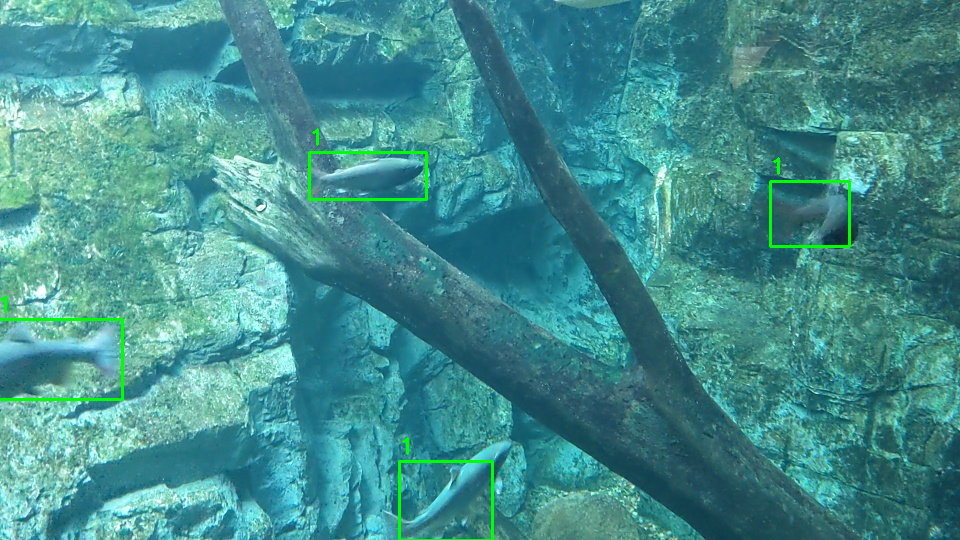

In [19]:
from google.colab.patches import cv2_imshow

cv2_imshow(debug_image)